<a href="https://colab.research.google.com/github/Sadia81214/new/blob/master/autism.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install xgboost imbalanced-learn shap

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import make_scorer, roc_auc_score, recall_score
from sklearn.calibration import CalibratedClassifierCV
import shap
import matplotlib.pyplot as plt
import seaborn as sns



In [2]:
X_adult = pd.read_csv('/content/csv_data-Adult.csv')
X_child = pd.read_csv('/content/csv_data-Children.csv')


print("Adult Dataset Shape:", X_adult.shape)
print("Child Dataset Shape:", X_child.shape)
print("\nAdult Columns:", X_adult.columns.tolist())
print("\nChild Columns:", X_child.columns.tolist())
print("\nAdult Sample:\n", X_adult.head())
print("\nChild Sample:\n", X_child.head())
print("\nMissing Values in Adult:\n", X_adult.isnull().sum())
print("\nMissing Values in Child:\n", X_child.isnull().sum())

Adult Dataset Shape: (704, 22)
Child Dataset Shape: (292, 22)

Adult Columns: ['id', 'A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score', 'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score', 'age', 'gender', 'ethnicity', 'jundice', 'austim', 'contry_of_res', 'used_app_before', 'result', 'age_desc', 'relation', 'Class/ASD']

Child Columns: ['id', 'A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score', 'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score', 'age', 'gender', 'ethnicity', 'jundice', 'austim', 'contry_of_res', 'used_app_before', 'result', 'age_desc', 'relation', 'Class/ASD']

Adult Sample:
    id  A1_Score  A2_Score  A3_Score  A4_Score  A5_Score  A6_Score  A7_Score  \
0   1         1         1         1         1         0         0         1   
1   2         1         1         0         1         0         0         0   
2   3         1         1         0         1         1         0         1   
3   4         1         1         0         1     

In [3]:
def preprocess_df(df, dataset_name=''):
    df = df.copy()

    drop_cols = ['id', 'used_app_before', 'age_desc']
    df = df.drop(columns=[col for col in drop_cols if col in df.columns])

    cat_cols = ['ethnicity', 'relation']
    for col in cat_cols:
        if col in df.columns:
            df[col] = df[col].replace('?', 'Unknown')


    df['age'] = pd.to_numeric(df['age'], errors='coerce')
    df['age'] = df['age'].fillna(df['age'].median())


    le = LabelEncoder()
    encode_cols = ['gender', 'ethnicity', 'jundice', 'austim', 'contry_of_res', 'relation']
    for col in encode_cols:
        if col in df.columns:
            df[col] = le.fit_transform(df[col].astype(str))


    if 'Class/ASD' in df.columns:
        df['Class/ASD'] = df['Class/ASD'].map({'YES': 1, 'NO': 0})


    X = df.drop('Class/ASD', axis=1)
    y = df['Class/ASD']


    scaler = StandardScaler()
    num_cols = ['age', 'result']
    if all(col in X.columns for col in num_cols):
        X[num_cols] = scaler.fit_transform(X[num_cols])


    smote = SMOTE(random_state=42)
    X_res, y_res = smote.fit_resample(X, y)


    print(f"\n{dataset_name} Preprocessed Shape:", X_res.shape)
    print(f"{dataset_name} Class Balance:\n", y_res.value_counts())
    print(f"{dataset_name} Missing Values:\n", X_res.isnull().sum().to_string())

    return X_res, y_res


X_adult = pd.read_csv('/content/csv_data-Adult.csv')
X_child = pd.read_csv('/content/csv_data-Children.csv')

X_adult_proc, y_adult = preprocess_df(X_adult, 'Adult')
X_child_proc, y_child = preprocess_df(X_child, 'Child')


Adult Preprocessed Shape: (1030, 18)
Adult Class Balance:
 Class/ASD
0    515
1    515
Name: count, dtype: int64
Adult Missing Values:
 A1_Score         0
A2_Score         0
A3_Score         0
A4_Score         0
A5_Score         0
A6_Score         0
A7_Score         0
A8_Score         0
A9_Score         0
A10_Score        0
age              0
gender           0
ethnicity        0
jundice          0
austim           0
contry_of_res    0
result           0
relation         0

Child Preprocessed Shape: (302, 18)
Child Class Balance:
 Class/ASD
0    151
1    151
Name: count, dtype: int64
Child Missing Values:
 A1_Score         0
A2_Score         0
A3_Score         0
A4_Score         0
A5_Score         0
A6_Score         0
A7_Score         0
A8_Score         0
A9_Score         0
A10_Score        0
age              0
gender           0
ethnicity        0
jundice          0
austim           0
contry_of_res    0
result           0
relation         0


In [4]:
X_adult_proc.to_csv('Adult_preprocessed.csv', index=False)
y_adult.to_csv('Adult_labels.csv', index=False)
X_child_proc.to_csv('Child_preprocessed.csv', index=False)
y_child.to_csv('Child_labels.csv', index=False)

In [5]:

X_adult_proc = pd.read_csv('Adult_preprocessed.csv')
y_adult = pd.read_csv('Adult_labels.csv')
X_child_proc = pd.read_csv('Child_preprocessed.csv')
y_child = pd.read_csv('Child_labels.csv')


print("Adult Preprocessed Shape:", X_adult_proc.shape)
print("\nAdult Preprocessed Sample:\n", X_adult_proc.head(5).to_string())
print("\nAdult Labels Sample:\n", y_adult.head(5).to_string())
print("\nChild Preprocessed Shape:", X_child_proc.shape)
print("\nChild Preprocessed Sample:\n", X_child_proc.head(5).to_string())
print("\nChild Labels Sample:\n", y_child.head(5).to_string())

Adult Preprocessed Shape: (1030, 18)

Adult Preprocessed Sample:
    A1_Score  A2_Score  A3_Score  A4_Score  A5_Score  A6_Score  A7_Score  A8_Score  A9_Score  A10_Score       age  gender  ethnicity  jundice  austim  contry_of_res    result  relation
0         1         1         1         1         0         0         1         1         0          0 -0.224025       0         10        0       0             64  0.450051         4
1         1         1         0         1         0         0         0         1         0          1 -0.345437       1          3        0       1             13  0.050006         4
2         1         1         0         1         1         0         1         1         1          1 -0.163319       1          3        1       1             56  1.250142         2
3         1         1         0         1         0         0         1         1         0          1  0.322327       0         10        0       1             64  0.450051         4
4         1   

In [6]:

X_adult_proc = pd.read_csv('Adult_preprocessed.csv')
y_adult = pd.read_csv('Adult_labels.csv')
X_child_proc = pd.read_csv('Child_preprocessed.csv')
y_child = pd.read_csv('Child_labels.csv')


y_adult = y_adult['Class/ASD'] if 'Class/ASD' in y_adult.columns else y_adult.values.ravel()
y_child = y_child['Class/ASD'] if 'Class/ASD' in y_child.columns else y_child.values.ravel()


print("Adult Preprocessed Shape:", X_adult_proc.shape, y_adult.shape)
print("Child Preprocessed Shape:", X_child_proc.shape, y_child.shape)


print("\nAdult Age Range: Min=", X_adult_proc['age'].min(), "Max=", X_adult_proc['age'].max())
print("Child Age Range: Min=", X_child_proc['age'].min(), "Max=", X_child_proc['age'].max())


def get_mapping(df, col, original_df):
    le = LabelEncoder()
    le.fit(original_df[col].replace('?', 'Unknown').astype(str))
    return dict(zip(le.classes_, le.transform(le.classes_)))


X_adult_orig = pd.read_csv('/content/csv_data-Adult.csv')
X_child_orig = pd.read_csv('/content/csv_data-Children.csv')


adult_ethnicity_map = get_mapping(X_adult_proc, 'ethnicity', X_adult_orig)
child_ethnicity_map = get_mapping(X_child_proc, 'ethnicity', X_child_orig)
print("\nAdult Ethnicity Mapping:", adult_ethnicity_map)
print("Child Ethnicity Mapping:", child_ethnicity_map)



Adult Preprocessed Shape: (1030, 18) (1030,)
Child Preprocessed Shape: (302, 18) (302,)

Adult Age Range: Min= -0.7703777339957056 Max= 21.447957664736048
Child Age Range: Min= -1.0016359789739648 Max= 1.9828304073566243

Adult Ethnicity Mapping: {'Asian': np.int64(0), 'Black': np.int64(1), 'Hispanic': np.int64(2), 'Latino': np.int64(3), 'Middle Eastern ': np.int64(4), 'Others': np.int64(5), 'Pasifika': np.int64(6), 'South Asian': np.int64(7), 'Turkish': np.int64(8), 'Unknown': np.int64(9), 'White-European': np.int64(10), 'others': np.int64(11)}
Child Ethnicity Mapping: {'Asian': np.int64(0), 'Black': np.int64(1), 'Hispanic': np.int64(2), 'Latino': np.int64(3), 'Middle Eastern ': np.int64(4), 'Others': np.int64(5), 'Pasifika': np.int64(6), 'South Asian': np.int64(7), 'Turkish': np.int64(8), 'Unknown': np.int64(9), 'White-European': np.int64(10)}


In [7]:
y_adult = y_adult.values.ravel()
y_child = y_child.values.ravel()


def specificity_score(y_true, y_pred):
    return recall_score(y_true, y_pred, pos_label=0)
specificity = make_scorer(specificity_score)


models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss')
}


def evaluate_within(X, y, name):
    results = []
    for m_name, model in models.items():
        cv_results = cross_validate(model, X, y, cv=5, scoring={'auroc': 'roc_auc', 'sensitivity': 'recall', 'specificity': specificity})
        results.append({
            'Model': m_name,
            'Dataset': name,
            'AUROC': np.mean(cv_results['test_auroc']),
            'Sensitivity': np.mean(cv_results['test_sensitivity']),
            'Specificity': np.mean(cv_results['test_specificity'])
        })
    return pd.DataFrame(results)


within_adult = evaluate_within(X_adult_proc, y_adult, 'Adult')
within_child = evaluate_within(X_child_proc, y_child, 'Child')


results = pd.concat([within_adult, within_child])
print("Within-Dataset Results:\n", results)
results.to_csv('within_dataset_results.csv', index=False)
print("\nResults saved to 'within_dataset_results.csv'")

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Within-Dataset Results:
                  Model Dataset     AUROC  Sensitivity  Specificity
0  Logistic Regression   Adult  1.000000     1.000000     0.996117
1        Random Forest   Adult  1.000000     1.000000     1.000000
2              XGBoost   Adult  1.000000     1.000000     1.000000
0  Logistic Regression   Child  0.999778     0.993333     0.993333
1        Random Forest   Child  1.000000     1.000000     1.000000
2              XGBoost   Child  1.000000     1.000000     1.000000

Results saved to 'within_dataset_results.csv'


In [8]:
X_adult_no_result = X_adult_proc.drop(columns=['result'], errors='ignore')
X_child_no_result = X_child_proc.drop(columns=['result'], errors='ignore')


def specificity_score(y_true, y_pred):
    return recall_score(y_true, y_pred, pos_label=0)


models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss')
}


cross_results = []
for m_name, model in models.items():
    # Train on Adult, test on Child
    model.fit(X_adult_no_result, y_adult)
    proba = model.predict_proba(X_child_no_result)[:, 1]
    preds = model.predict(X_child_no_result)
    cross_results.append({
        'Model': m_name,
        'Train': 'Adult',
        'Test': 'Child',
        'AUROC': roc_auc_score(y_child, proba),
        'Sensitivity': recall_score(y_child, preds),
        'Specificity': specificity_score(y_child, preds)
    })

    # Train on Child, test on Adult
    model.fit(X_child_no_result, y_child)
    proba = model.predict_proba(X_adult_no_result)[:, 1]
    preds = model.predict(X_adult_no_result)
    cross_results.append({
        'Model': m_name,
        'Train': 'Child',
        'Test': 'Adult',
        'AUROC': roc_auc_score(y_adult, proba),
        'Sensitivity': recall_score(y_adult, preds),
        'Specificity': specificity_score(y_adult, preds)
    })

cross_df = pd.DataFrame(cross_results)
print("Cross-Dataset Results (without result column):\n", cross_df)

# Generalization gap (using within-dataset results for comparison)
within_results = pd.read_csv('within_dataset_results.csv')
gap = cross_df.groupby('Model')['AUROC'].mean() - within_results.groupby('Model')['AUROC'].mean()
print("\nGeneralization Gap (lower better):\n", gap)

# Save results
cross_df.to_csv('cross_dataset_results.csv', index=False)
print("\nResults saved to 'cross_dataset_results.csv'")

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Cross-Dataset Results (without result column):
                  Model  Train   Test     AUROC  Sensitivity  Specificity
0  Logistic Regression  Adult  Child  0.993772     0.993377     0.887417
1  Logistic Regression  Child  Adult  0.983052     0.873786     0.947573
2        Random Forest  Adult  Child  0.956011     0.874172     0.854305
3        Random Forest  Child  Adult  0.969835     0.817476     0.949515
4              XGBoost  Adult  Child  0.956449     0.907285     0.841060
5              XGBoost  Child  Adult  0.969153     0.864078     0.920388

Generalization Gap (lower better):
 Model
Logistic Regression   -0.011477
Random Forest         -0.037077
XGBoost               -0.037199
Name: AUROC, dtype: float64

Results saved to 'cross_dataset_results.csv'


In [9]:

demographic_cols = ['age', 'gender', 'ethnicity', 'jundice', 'austim', 'contry_of_res', 'relation']
X_adult_demo = X_adult_proc[demographic_cols]
X_child_demo = X_child_proc[demographic_cols]


def specificity_score(y_true, y_pred):
    return recall_score(y_true, y_pred, pos_label=0)

# Models
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss')
}

# Cross-dataset evaluation
cross_results = []
for m_name, model in models.items():
    # Train on Adult, test on Child
    model.fit(X_adult_demo, y_adult)
    proba = model.predict_proba(X_child_demo)[:, 1]
    preds = model.predict(X_child_demo)
    cross_results.append({
        'Model': m_name,
        'Train': 'Adult',
        'Test': 'Child',
        'AUROC': roc_auc_score(y_child, proba),
        'Sensitivity': recall_score(y_child, preds),
        'Specificity': specificity_score(y_child, preds)
    })

    # Train on Child, test on Adult
    model.fit(X_child_demo, y_child)
    proba = model.predict_proba(X_adult_demo)[:, 1]
    preds = model.predict(X_adult_demo)
    cross_results.append({
        'Model': m_name,
        'Train': 'Child',
        'Test': 'Adult',
        'AUROC': roc_auc_score(y_adult, proba),
        'Sensitivity': recall_score(y_adult, preds),
        'Specificity': specificity_score(y_adult, preds)
    })

cross_df = pd.DataFrame(cross_results)
print("Cross-Dataset Results (Demographic Features Only):\n", cross_df)

# Generalization gap (using your within-dataset results)
within_results = pd.read_csv('within_dataset_results.csv')
gap = cross_df.groupby('Model')['AUROC'].mean() - within_results.groupby('Model')['AUROC'].mean()
print("\nGeneralization Gap (lower better):\n", gap)

# Save results
cross_df.to_csv('cross_dataset_demo_results.csv', index=False)
print("\nResults saved to 'cross_dataset_demo_results.csv'")

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Cross-Dataset Results (Demographic Features Only):
                  Model  Train   Test     AUROC  Sensitivity  Specificity
0  Logistic Regression  Adult  Child  0.563352     0.874172     0.158940
1  Logistic Regression  Child  Adult  0.583623     0.027184     0.974757
2        Random Forest  Adult  Child  0.503224     0.251656     0.735099
3        Random Forest  Child  Adult  0.586713     0.328155     0.813592
4              XGBoost  Adult  Child  0.510372     0.370861     0.642384
5              XGBoost  Child  Adult  0.504302     0.357282     0.652427

Generalization Gap (lower better):
 Model
Logistic Regression   -0.426401
Random Forest         -0.455032
XGBoost               -0.492663
Name: AUROC, dtype: float64

Results saved to 'cross_dataset_demo_results.csv'


In [10]:

X_adult_no_result = X_adult_proc.drop(columns=['result'], errors='ignore')
X_child_no_result = X_child_proc.drop(columns=['result'], errors='ignore')


def specificity_score(y_true, y_pred):
    return recall_score(y_true, y_pred, pos_label=0)


models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss')
}

# Cross-dataset evaluation
cross_results = []
for m_name, model in models.items():
    # Train on Adult, test on Child
    model.fit(X_adult_no_result, y_adult)
    proba = model.predict_proba(X_child_no_result)[:, 1]
    preds = model.predict(X_child_no_result)
    cross_results.append({
        'Model': m_name,
        'Train': 'Adult',
        'Test': 'Child',
        'AUROC': roc_auc_score(y_child, proba),
        'Sensitivity': recall_score(y_child, preds),
        'Specificity': specificity_score(y_child, preds)
    })

    # Train on Child, test on Adult
    model.fit(X_child_no_result, y_child)
    proba = model.predict_proba(X_adult_no_result)[:, 1]
    preds = model.predict(X_adult_no_result)
    cross_results.append({
        'Model': m_name,
        'Train': 'Child',
        'Test': 'Adult',
        'AUROC': roc_auc_score(y_adult, proba),
        'Sensitivity': recall_score(y_adult, preds),
        'Specificity': specificity_score(y_adult, preds)
    })

cross_df = pd.DataFrame(cross_results)
print("Cross-Dataset Results (All Features Except result):\n", cross_df)

# Generalization gap
within_results = pd.read_csv('within_dataset_results.csv')
gap = cross_df.groupby('Model')['AUROC'].mean() - within_results.groupby('Model')['AUROC'].mean()
print("\nGeneralization Gap (lower better):\n", gap)

# Save results
cross_df.to_csv('cross_dataset_all_features_results.csv', index=False)
print("\nResults saved to 'cross_dataset_all_features_results.csv'")

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Cross-Dataset Results (All Features Except result):
                  Model  Train   Test     AUROC  Sensitivity  Specificity
0  Logistic Regression  Adult  Child  0.993772     0.993377     0.887417
1  Logistic Regression  Child  Adult  0.983052     0.873786     0.947573
2        Random Forest  Adult  Child  0.956011     0.874172     0.854305
3        Random Forest  Child  Adult  0.969835     0.817476     0.949515
4              XGBoost  Adult  Child  0.956449     0.907285     0.841060
5              XGBoost  Child  Adult  0.969153     0.864078     0.920388

Generalization Gap (lower better):
 Model
Logistic Regression   -0.011477
Random Forest         -0.037077
XGBoost               -0.037199
Name: AUROC, dtype: float64

Results saved to 'cross_dataset_all_features_results.csv'


In [11]:
def preprocess_df_no_smote(df, dataset_name=''):
    df = df.copy()
    # Drop irrelevant
    drop_cols = ['id', 'used_app_before', 'age_desc']
    df = df.drop(columns=[col for col in drop_cols if col in df.columns])

    # Handle '?'
    cat_cols = ['ethnicity', 'relation']
    for col in cat_cols:
        if col in df.columns:
            df[col] = df[col].replace('?', 'Unknown')

    # Handle age
    df['age'] = pd.to_numeric(df['age'], errors='coerce')
    df['age'] = df['age'].fillna(df['age'].median())

    # Encode categorical
    le = LabelEncoder()
    encode_cols = ['gender', 'ethnicity', 'jundice', 'austim', 'contry_of_res', 'relation']
    for col in encode_cols:
        if col in df.columns:
            df[col] = le.fit_transform(df[col].astype(str))

    # Encode target
    if 'Class/ASD' in df.columns:
        df['Class/ASD'] = df['Class/ASD'].map({'YES': 1, 'NO': 0})

    # Split X/y
    X = df.drop('Class/ASD', axis=1)
    y = df['Class/ASD']

    # Scale numerical
    scaler = StandardScaler()
    num_cols = ['age', 'result']
    if all(col in X.columns for col in num_cols):
        X[num_cols] = scaler.fit_transform(X[num_cols])

    # Verify
    print(f"\n{dataset_name} Preprocessed Shape:", X.shape)
    print(f"{dataset_name} Class Balance:\n", y.value_counts())
    print(f"{dataset_name} Missing Values:\n", X.isnull().sum().to_string())

    return X, y

# Load and preprocess
X_adult = pd.read_csv('/content/csv_data-Adult.csv')
X_child = pd.read_csv('/content/csv_data-Children.csv')
X_adult_proc, y_adult = preprocess_df_no_smote(X_adult, 'Adult')
X_child_proc, y_child = preprocess_df_no_smote(X_child, 'Child')

# Save
X_adult_proc.to_csv('Adult_preprocessed_no_smote.csv', index=False)
y_adult.to_csv('Adult_labels_no_smote.csv', index=False)
X_child_proc.to_csv('Child_preprocessed_no_smote.csv', index=False)
y_child.to_csv('Child_labels_no_smote.csv', index=False)


Adult Preprocessed Shape: (704, 18)
Adult Class Balance:
 Class/ASD
0    515
1    189
Name: count, dtype: int64
Adult Missing Values:
 A1_Score         0
A2_Score         0
A3_Score         0
A4_Score         0
A5_Score         0
A6_Score         0
A7_Score         0
A8_Score         0
A9_Score         0
A10_Score        0
age              0
gender           0
ethnicity        0
jundice          0
austim           0
contry_of_res    0
result           0
relation         0

Child Preprocessed Shape: (292, 18)
Child Class Balance:
 Class/ASD
0    151
1    141
Name: count, dtype: int64
Child Missing Values:
 A1_Score         0
A2_Score         0
A3_Score         0
A4_Score         0
A5_Score         0
A6_Score         0
A7_Score         0
A8_Score         0
A9_Score         0
A10_Score        0
age              0
gender           0
ethnicity        0
jundice          0
austim           0
contry_of_res    0
result           0
relation         0


In [12]:

X_adult_proc = pd.read_csv('Adult_preprocessed_no_smote.csv')
y_adult = pd.read_csv('Adult_labels_no_smote.csv')
X_child_proc = pd.read_csv('Child_preprocessed_no_smote.csv')
y_child = pd.read_csv('Child_labels_no_smote.csv')

# Fix y
y_adult = y_adult.values.ravel()
y_child = y_child.values.ravel()

# Exclude 'result'
X_adult_no_result = X_adult_proc.drop(columns=['result'], errors='ignore')
X_child_no_result = X_child_proc.drop(columns=['result'], errors='ignore')

# Specificity scorer
def specificity_score(y_true, y_pred):
    return recall_score(y_true, y_pred, pos_label=0)

# Models
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss')
}

# Cross-dataset evaluation
cross_results = []
for m_name, model in models.items():
    # Train on Adult, test on Child
    model.fit(X_adult_no_result, y_adult)
    proba = model.predict_proba(X_child_no_result)[:, 1]
    preds = model.predict(X_child_no_result)
    cross_results.append({
        'Model': m_name,
        'Train': 'Adult',
        'Test': 'Child',
        'AUROC': roc_auc_score(y_child, proba),
        'Sensitivity': recall_score(y_child, preds),
        'Specificity': specificity_score(y_child, preds)
    })

    # Train on Child, test on Adult
    model.fit(X_child_no_result, y_child)
    proba = model.predict_proba(X_adult_no_result)[:, 1]
    preds = model.predict(X_adult_no_result)
    cross_results.append({
        'Model': m_name,
        'Train': 'Child',
        'Test': 'Adult',
        'AUROC': roc_auc_score(y_adult, proba),
        'Sensitivity': recall_score(y_adult, preds),
        'Specificity': specificity_score(y_adult, preds)
    })

cross_df = pd.DataFrame(cross_results)
print("Cross-Dataset Results (No SMOTE, All Features Except result):\n", cross_df)

# Save results
cross_df.to_csv('cross_dataset_no_smote_results.csv', index=False)
print("\nResults saved to 'cross_dataset_no_smote_results.csv'")

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Cross-Dataset Results (No SMOTE, All Features Except result):
                  Model  Train   Test     AUROC  Sensitivity  Specificity
0  Logistic Regression  Adult  Child  1.000000     0.985816     1.000000
1  Logistic Regression  Child  Adult  0.999723     1.000000     0.959223
2        Random Forest  Adult  Child  0.969917     0.815603     0.927152
3        Random Forest  Child  Adult  0.991658     0.952381     0.943689
4              XGBoost  Adult  Child  0.987929     0.907801     0.933775
5              XGBoost  Child  Adult  0.994791     0.968254     0.928155

Results saved to 'cross_dataset_no_smote_results.csv'


In [13]:
def preprocess_df_subset(df, dataset_name=''):
    df = df.copy()
    # Drop irrelevant
    drop_cols = ['id', 'used_app_before', 'age_desc', 'A6_Score', 'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score', 'result']
    df = df.drop(columns=[col for col in drop_cols if col in df.columns])

    # Handle '?'
    cat_cols = ['ethnicity', 'relation']
    for col in cat_cols:
        if col in df.columns:
            df[col] = df[col].replace('?', 'Unknown')

    # Handle age
    df['age'] = pd.to_numeric(df['age'], errors='coerce')
    df['age'] = df['age'].fillna(df['age'].median())

    # Encode categorical
    le = LabelEncoder()
    encode_cols = ['gender', 'ethnicity', 'jundice', 'austim', 'contry_of_res', 'relation']
    for col in encode_cols:
        if col in df.columns:
            df[col] = le.fit_transform(df[col].astype(str))

    # Encode target
    if 'Class/ASD' in df.columns:
        df['Class/ASD'] = df['Class/ASD'].map({'YES': 1, 'NO': 0})

    # Split X/y
    X = df.drop('Class/ASD', axis=1)
    y = df['Class/ASD']

    # Scale numerical
    scaler = StandardScaler()
    num_cols = ['age']
    if all(col in X.columns for col in num_cols):
        X[num_cols] = scaler.fit_transform(X[num_cols])

    # Verify
    print(f"\n{dataset_name} Preprocessed Shape:", X.shape)
    print(f"{dataset_name} Class Balance:\n", y.value_counts())
    print(f"{dataset_name} Missing Values:\n", X.isnull().sum().to_string())

    return X, y

# Load and preprocess
X_adult = pd.read_csv('/content/csv_data-Adult.csv')
X_child = pd.read_csv('/content/csv_data-Children.csv')
X_adult_proc, y_adult = preprocess_df_subset(X_adult, 'Adult')
X_child_proc, y_child = preprocess_df_subset(X_child, 'Child')

# Save
X_adult_proc.to_csv('Adult_preprocessed_subset.csv', index=False)
y_adult.to_csv('Adult_labels_subset.csv', index=False)
X_child_proc.to_csv('Child_preprocessed_subset.csv', index=False)
y_child.to_csv('Child_labels_subset.csv', index=False)


Adult Preprocessed Shape: (704, 12)
Adult Class Balance:
 Class/ASD
0    515
1    189
Name: count, dtype: int64
Adult Missing Values:
 A1_Score         0
A2_Score         0
A3_Score         0
A4_Score         0
A5_Score         0
age              0
gender           0
ethnicity        0
jundice          0
austim           0
contry_of_res    0
relation         0

Child Preprocessed Shape: (292, 12)
Child Class Balance:
 Class/ASD
0    151
1    141
Name: count, dtype: int64
Child Missing Values:
 A1_Score         0
A2_Score         0
A3_Score         0
A4_Score         0
A5_Score         0
age              0
gender           0
ethnicity        0
jundice          0
austim           0
contry_of_res    0
relation         0


In [14]:

X_adult_proc = pd.read_csv('Adult_preprocessed_subset.csv')
y_adult = pd.read_csv('Adult_labels_subset.csv')
X_child_proc = pd.read_csv('Child_preprocessed_subset.csv')
y_child = pd.read_csv('Child_labels_subset.csv')

# Fix y
y_adult = y_adult.values.ravel()
y_child = y_child.values.ravel()

# Specificity scorer
def specificity_score(y_true, y_pred):
    return recall_score(y_true, y_pred, pos_label=0)
specificity = make_scorer(specificity_score)

# Models
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss')
}

# Within-dataset evaluation
def evaluate_within(X, y, name):
    results = []
    for m_name, model in models.items():
        cv_results = cross_validate(model, X, y, cv=5, scoring={'auroc': 'roc_auc', 'sensitivity': 'recall', 'specificity': specificity})
        results.append({
            'Model': m_name,
            'Dataset': name,
            'AUROC': np.mean(cv_results['test_auroc']),
            'Sensitivity': np.mean(cv_results['test_sensitivity']),
            'Specificity': np.mean(cv_results['test_specificity'])
        })
    return pd.DataFrame(results)

# Run within
within_adult = evaluate_within(X_adult_proc, y_adult, 'Adult')
within_child = evaluate_within(X_child_proc, y_child, 'Child')
within_results = pd.concat([within_adult, within_child])
print("Within-Dataset Results (Subset Features):\n", within_results)
within_results.to_csv('within_dataset_subset_results.csv', index=False)

# Cross-dataset evaluation
cross_results = []
for m_name, model in models.items():
    # Train on Adult, test on Child
    model.fit(X_adult_proc, y_adult)
    proba = model.predict_proba(X_child_proc)[:, 1]
    preds = model.predict(X_child_proc)
    cross_results.append({
        'Model': m_name,
        'Train': 'Adult',
        'Test': 'Child',
        'AUROC': roc_auc_score(y_child, proba),
        'Sensitivity': recall_score(y_child, preds),
        'Specificity': specificity_score(y_child, preds)
    })

    # Train on Child, test on Adult
    model.fit(X_child_proc, y_child)
    proba = model.predict_proba(X_adult_proc)[:, 1]
    preds = model.predict(X_adult_proc)
    cross_results.append({
        'Model': m_name,
        'Train': 'Child',
        'Test': 'Adult',
        'AUROC': roc_auc_score(y_adult, proba),
        'Sensitivity': recall_score(y_adult, preds),
        'Specificity': specificity_score(y_adult, preds)
    })

cross_df = pd.DataFrame(cross_results)
print("\nCross-Dataset Results (Subset Features):\n", cross_df)

# Generalization gap
gap = cross_df.groupby('Model')['AUROC'].mean() - within_results.groupby('Model')['AUROC'].mean()
print("\nGeneralization Gap (lower better):\n", gap)

# Save results
cross_df.to_csv('cross_dataset_subset_results.csv', index=False)
print("\nResults saved to 'cross_dataset_subset_results.csv'")

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Within-Dataset Results (Subset Features):
                  Model Dataset     AUROC  Sensitivity  Specificity
0  Logistic Regression   Adult  0.948025     0.772688     0.932039
1        Random Forest   Adult  0.933839     0.740825     0.928155
2              XGBoost   Adult  0.937505     0.730583     0.918447
0  Logistic Regression   Child  0.922505     0.843350     0.833333
1        Random Forest   Child  0.911433     0.808621     0.880000
2              XGBoost   Child  0.883960     0.773153     0.813763


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Cross-Dataset Results (Subset Features):
                  Model  Train   Test     AUROC  Sensitivity  Specificity
0  Logistic Regression  Adult  Child  0.916068     0.730496     0.907285
1  Logistic Regression  Child  Adult  0.943294     0.904762     0.825243
2        Random Forest  Adult  Child  0.901883     0.666667     0.940397
3        Random Forest  Child  Adult  0.941403     0.878307     0.860194
4              XGBoost  Adult  Child  0.876896     0.680851     0.894040
5              XGBoost  Child  Adult  0.932455     0.910053     0.827184

Generalization Gap (lower better):
 Model
Logistic Regression   -0.005584
Random Forest         -0.000993
XGBoost               -0.006057
Name: AUROC, dtype: float64

Results saved to 'cross_dataset_subset_results.csv'


In [15]:
def preprocess_df_minimal(df, dataset_name=''):
    df = df.copy()
    # Drop irrelevant and most AQ-10
    drop_cols = ['id', 'used_app_before', 'age_desc', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score', 'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score', 'result']
    df = df.drop(columns=[col for col in drop_cols if col in df.columns])

    # Handle '?'
    cat_cols = ['ethnicity', 'relation']
    for col in cat_cols:
        if col in df.columns:
            df[col] = df[col].replace('?', 'Unknown')

    # Handle age
    df['age'] = pd.to_numeric(df['age'], errors='coerce')
    df['age'] = df['age'].fillna(df['age'].median())

    # Encode categorical
    le = LabelEncoder()
    encode_cols = ['gender', 'ethnicity', 'jundice', 'austim', 'contry_of_res', 'relation']
    for col in encode_cols:
        if col in df.columns:
            df[col] = le.fit_transform(df[col].astype(str))

    # Encode target
    if 'Class/ASD' in df.columns:
        df['Class/ASD'] = df['Class/ASD'].map({'YES': 1, 'NO': 0})

    # Split X/y
    X = df.drop('Class/ASD', axis=1)
    y = df['Class/ASD']

    # Scale numerical
    scaler = StandardScaler()
    num_cols = ['age']
    if all(col in X.columns for col in num_cols):
        X[num_cols] = scaler.fit_transform(X[num_cols])

    # Verify
    print(f"\n{dataset_name} Preprocessed Shape:", X.shape)
    print(f"{dataset_name} Class Balance:\n", y.value_counts())
    print(f"{dataset_name} Missing Values:\n", X.isnull().sum().to_string())

    return X, y

# Load and preprocess
X_adult = pd.read_csv('/content/csv_data-Adult.csv')
X_child = pd.read_csv('/content/csv_data-Children.csv')
X_adult_proc, y_adult = preprocess_df_minimal(X_adult, 'Adult')
X_child_proc, y_child = preprocess_df_minimal(X_child, 'Child')

# Save
X_adult_proc.to_csv('Adult_preprocessed_minimal.csv', index=False)
y_adult.to_csv('Adult_labels_minimal.csv', index=False)
X_child_proc.to_csv('Child_preprocessed_minimal.csv', index=False)
y_child.to_csv('Child_labels_minimal.csv', index=False)


Adult Preprocessed Shape: (704, 9)
Adult Class Balance:
 Class/ASD
0    515
1    189
Name: count, dtype: int64
Adult Missing Values:
 A1_Score         0
A2_Score         0
age              0
gender           0
ethnicity        0
jundice          0
austim           0
contry_of_res    0
relation         0

Child Preprocessed Shape: (292, 9)
Child Class Balance:
 Class/ASD
0    151
1    141
Name: count, dtype: int64
Child Missing Values:
 A1_Score         0
A2_Score         0
age              0
gender           0
ethnicity        0
jundice          0
austim           0
contry_of_res    0
relation         0


In [16]:
# Load new preprocessed CSVs
X_adult_proc = pd.read_csv('Adult_preprocessed_minimal.csv')
y_adult = pd.read_csv('Adult_labels_minimal.csv')
X_child_proc = pd.read_csv('Child_preprocessed_minimal.csv')
y_child = pd.read_csv('Child_labels_minimal.csv')

# Fix y
y_adult = y_adult.values.ravel()
y_child = y_child.values.ravel()

# Specificity scorer
def specificity_score(y_true, y_pred):
    return recall_score(y_true, y_pred, pos_label=0)
specificity = make_scorer(specificity_score)

# Models
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss')
}

# Within-dataset evaluation
def evaluate_within(X, y, name):
    results = []
    for m_name, model in models.items():
        cv_results = cross_validate(model, X, y, cv=5, scoring={'auroc': 'roc_auc', 'sensitivity': 'recall', 'specificity': specificity})
        results.append({
            'Model': m_name,
            'Dataset': name,
            'AUROC': np.mean(cv_results['test_auroc']),
            'Sensitivity': np.mean(cv_results['test_sensitivity']),
            'Specificity': np.mean(cv_results['test_specificity'])
        })
    return pd.DataFrame(results)

# Run within
within_adult = evaluate_within(X_adult_proc, y_adult, 'Adult')
within_child = evaluate_within(X_child_proc, y_child, 'Child')
within_results = pd.concat([within_adult, within_child])
print("Within-Dataset Results (Minimal Features):\n", within_results)
within_results.to_csv('within_dataset_minimal_results.csv', index=False)

# Cross-dataset evaluation
cross_results = []
for m_name, model in models.items():
    # Train on Adult, test on Child
    model.fit(X_adult_proc, y_adult)
    proba = model.predict_proba(X_child_proc)[:, 1]
    preds = model.predict(X_child_proc)
    cross_results.append({
        'Model': m_name,
        'Train': 'Adult',
        'Test': 'Child',
        'AUROC': roc_auc_score(y_child, proba),
        'Sensitivity': recall_score(y_child, preds),
        'Specificity': specificity_score(y_child, preds)
    })

    # Train on Child, test on Adult
    model.fit(X_child_proc, y_child)
    proba = model.predict_proba(X_adult_proc)[:, 1]
    preds = model.predict(X_adult_proc)
    cross_results.append({
        'Model': m_name,
        'Train': 'Child',
        'Test': 'Adult',
        'AUROC': roc_auc_score(y_adult, proba),
        'Sensitivity': recall_score(y_adult, preds),
        'Specificity': specificity_score(y_adult, preds)
    })

cross_df = pd.DataFrame(cross_results)
print("\nCross-Dataset Results (Minimal Features):\n", cross_df)

# Generalization gap
gap = cross_df.groupby('Model')['AUROC'].mean() - within_results.groupby('Model')['AUROC'].mean()
print("\nGeneralization Gap (lower better):\n", gap)

# Save results
cross_df.to_csv('cross_dataset_minimal_results.csv', index=False)
print("\nResults saved to 'cross_dataset_minimal_results.csv'")

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Within-Dataset Results (Minimal Features):
                  Model Dataset     AUROC  Sensitivity  Specificity
0  Logistic Regression   Adult  0.786013     0.396302     0.889320
1        Random Forest   Adult  0.762131     0.444808     0.858252
2              XGBoost   Adult  0.748002     0.439687     0.842718
0  Logistic Regression   Child  0.728535     0.666749     0.654409
1        Random Forest   Child  0.748230     0.716502     0.641720
2              XGBoost   Child  0.702112     0.652709     0.615269

Cross-Dataset Results (Minimal Features):
                  Model  Train   Test     AUROC  Sensitivity  Specificity
0  Logistic Regression  Adult  Child  0.740313     0.460993     0.807947
1  Logistic Regression  Child  Adult  0.748087     0.677249     0.755340
2        Random Forest  Adult  Child  0.686182     0.156028     0.933775
3        Random Forest  Child  Adult  0.718205     0.698413     0.631068
4              XGBoost  Adult  Child  0.652670     0.156028     0.920530
5    

In [17]:
def preprocess_df_3aq(df, dataset_name=''):
    df = df.copy()
    # Drop irrelevant and some AQ-10
    drop_cols = ['id', 'used_app_before', 'age_desc', 'A4_Score', 'A5_Score', 'A6_Score', 'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score', 'result']
    df = df.drop(columns=[col for col in drop_cols if col in df.columns])

    # Handle '?'
    cat_cols = ['ethnicity', 'relation']
    for col in cat_cols:
        if col in df.columns:
            df[col] = df[col].replace('?', 'Unknown')

    # Handle age
    df['age'] = pd.to_numeric(df['age'], errors='coerce')
    df['age'] = df['age'].fillna(df['age'].median())

    # Encode categorical
    le = LabelEncoder()
    encode_cols = ['gender', 'ethnicity', 'jundice', 'austim', 'contry_of_res', 'relation']
    for col in encode_cols:
        if col in df.columns:
            df[col] = le.fit_transform(df[col].astype(str))

    # Encode target
    if 'Class/ASD' in df.columns:
        df['Class/ASD'] = df['Class/ASD'].map({'YES': 1, 'NO': 0})

    # Split X/y
    X = df.drop('Class/ASD', axis=1)
    y = df['Class/ASD']

    # Scale numerical
    scaler = StandardScaler()
    num_cols = ['age']
    if all(col in X.columns for col in num_cols):
        X[num_cols] = scaler.fit_transform(X[num_cols])

    # Verify
    print(f"\n{dataset_name} Preprocessed Shape:", X.shape)
    print(f"{dataset_name} Class Balance:\n", y.value_counts())
    print(f"{dataset_name} Missing Values:\n", X.isnull().sum().to_string())

    return X, y

# Load and preprocess
X_adult = pd.read_csv('/content/csv_data-Adult.csv')
X_child = pd.read_csv('/content/csv_data-Children.csv')
X_adult_proc, y_adult = preprocess_df_3aq(X_adult, 'Adult')
X_child_proc, y_child = preprocess_df_3aq(X_child, 'Child')

# Save
X_adult_proc.to_csv('Adult_preprocessed_3aq.csv', index=False)
y_adult.to_csv('Adult_labels_3aq.csv', index=False)
X_child_proc.to_csv('Child_preprocessed_3aq.csv', index=False)
y_child.to_csv('Child_labels_3aq.csv', index=False)


Adult Preprocessed Shape: (704, 10)
Adult Class Balance:
 Class/ASD
0    515
1    189
Name: count, dtype: int64
Adult Missing Values:
 A1_Score         0
A2_Score         0
A3_Score         0
age              0
gender           0
ethnicity        0
jundice          0
austim           0
contry_of_res    0
relation         0

Child Preprocessed Shape: (292, 10)
Child Class Balance:
 Class/ASD
0    151
1    141
Name: count, dtype: int64
Child Missing Values:
 A1_Score         0
A2_Score         0
A3_Score         0
age              0
gender           0
ethnicity        0
jundice          0
austim           0
contry_of_res    0
relation         0


In [18]:

X_adult_proc = pd.read_csv('Adult_preprocessed_3aq.csv')
y_adult = pd.read_csv('Adult_labels_3aq.csv')
X_child_proc = pd.read_csv('Child_preprocessed_3aq.csv')
y_child = pd.read_csv('Child_labels_3aq.csv')

# Fix y
y_adult = y_adult.values.ravel()
y_child = y_child.values.ravel()

# Specificity scorer
def specificity_score(y_true, y_pred):
    return recall_score(y_true, y_pred, pos_label=0)
specificity = make_scorer(specificity_score)

# Models
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss')
}

# Within-dataset evaluation
def evaluate_within(X, y, name):
    results = []
    for m_name, model in models.items():
        cv_results = cross_validate(model, X, y, cv=5, scoring={'auroc': 'roc_auc', 'sensitivity': 'recall', 'specificity': specificity})
        results.append({
            'Model': m_name,
            'Dataset': name,
            'AUROC': np.mean(cv_results['test_auroc']),
            'Sensitivity': np.mean(cv_results['test_sensitivity']),
            'Specificity': np.mean(cv_results['test_specificity'])
        })
    return pd.DataFrame(results)

# Run within
within_adult = evaluate_within(X_adult_proc, y_adult, 'Adult')
within_child = evaluate_within(X_child_proc, y_child, 'Child')
within_results = pd.concat([within_adult, within_child])
print("Within-Dataset Results (3 AQ-10 Features):\n", within_results)
within_results.to_csv('within_dataset_3aq_results.csv', index=False)

# Cross-dataset evaluation
cross_results = []
for m_name, model in models.items():
    # Train on Adult, test on Child
    model.fit(X_adult_proc, y_adult)
    proba = model.predict_proba(X_child_proc)[:, 1]
    preds = model.predict(X_child_proc)
    cross_results.append({
        'Model': m_name,
        'Train': 'Adult',
        'Test': 'Child',
        'AUROC': roc_auc_score(y_child, proba),
        'Sensitivity': recall_score(y_child, preds),
        'Specificity': specificity_score(y_child, preds)
    })

    # Train on Child, test on Adult
    model.fit(X_child_proc, y_child)
    proba = model.predict_proba(X_adult_proc)[:, 1]
    preds = model.predict(X_adult_proc)
    cross_results.append({
        'Model': m_name,
        'Train': 'Child',
        'Test': 'Adult',
        'AUROC': roc_auc_score(y_adult, proba),
        'Sensitivity': recall_score(y_adult, preds),
        'Specificity': specificity_score(y_adult, preds)
    })

cross_df = pd.DataFrame(cross_results)
print("\nCross-Dataset Results (3 AQ-10 Features):\n", cross_df)

# Generalization gap
gap = cross_df.groupby('Model')['AUROC'].mean() - within_results.groupby('Model')['AUROC'].mean()
print("\nGeneralization Gap (lower better):\n", gap)

# Save results
cross_df.to_csv('cross_dataset_3aq_results.csv', index=False)
print("\nResults saved to 'cross_dataset_3aq_results.csv'")

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Within-Dataset Results (3 AQ-10 Features):
                  Model Dataset     AUROC  Sensitivity  Specificity
0  Logistic Regression   Adult  0.857114     0.597866     0.900971
1        Random Forest   Adult  0.822218     0.545661     0.883495
2              XGBoost   Adult  0.822034     0.540114     0.869903
0  Logistic Regression   Child  0.818752     0.751724     0.753978
1        Random Forest   Child  0.797278     0.751970     0.720645
2              XGBoost   Child  0.786092     0.687685     0.713978


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Cross-Dataset Results (3 AQ-10 Features):
                  Model  Train   Test     AUROC  Sensitivity  Specificity
0  Logistic Regression  Adult  Child  0.815744     0.638298     0.854305
1  Logistic Regression  Child  Adult  0.850984     0.761905     0.803883
2        Random Forest  Adult  Child  0.811352     0.475177     0.900662
3        Random Forest  Child  Adult  0.839441     0.777778     0.782524
4              XGBoost  Adult  Child  0.778099     0.404255     0.867550
5              XGBoost  Child  Adult  0.840700     0.820106     0.710680

Generalization Gap (lower better):
 Model
Logistic Regression   -0.004569
Random Forest          0.015648
XGBoost                0.005336
Name: AUROC, dtype: float64

Results saved to 'cross_dataset_3aq_results.csv'


In [19]:

X_adult_proc = pd.read_csv('Adult_preprocessed_3aq.csv')
y_adult = pd.read_csv('Adult_labels_3aq.csv')
X_child_proc = pd.read_csv('Child_preprocessed_3aq.csv')
y_child = pd.read_csv('Child_labels_3aq.csv')

# Fix y
y_adult = y_adult.values.ravel()
y_child = y_child.values.ravel()

# Specificity scorer
def specificity_score(y_true, y_pred):
    return recall_score(y_true, y_pred, pos_label=0)
specificity = make_scorer(specificity_score)

# Models with balanced class weights
models = {
    'Logistic Regression': LogisticRegression(random_state=42, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(random_state=42, class_weight='balanced'),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss', scale_pos_weight=len(y_adult)/(2*sum(y_adult)))  # Adjust for Adult imbalance
}

# Within-dataset evaluation
def evaluate_within(X, y, name):
    results = []
    for m_name, model in models.items():
        cv_results = cross_validate(model, X, y, cv=5, scoring={'auroc': 'roc_auc', 'sensitivity': 'recall', 'specificity': specificity})
        results.append({
            'Model': m_name,
            'Dataset': name,
            'AUROC': np.mean(cv_results['test_auroc']),
            'Sensitivity': np.mean(cv_results['test_sensitivity']),
            'Specificity': np.mean(cv_results['test_specificity'])
        })
    return pd.DataFrame(results)

# Run within
within_adult = evaluate_within(X_adult_proc, y_adult, 'Adult')
within_child = evaluate_within(X_child_proc, y_child, 'Child')
within_results = pd.concat([within_adult, within_child])
print("Within-Dataset Results (3 AQ-10, Balanced Weights):\n", within_results)
within_results.to_csv('within_dataset_3aq_balanced_results.csv', index=False)

# Cross-dataset evaluation
cross_results = []
for m_name, model in models.items():
    # Train on Adult, test on Child
    model.fit(X_adult_proc, y_adult)
    proba = model.predict_proba(X_child_proc)[:, 1]
    preds = model.predict(X_child_proc)
    cross_results.append({
        'Model': m_name,
        'Train': 'Adult',
        'Test': 'Child',
        'AUROC': roc_auc_score(y_child, proba),
        'Sensitivity': recall_score(y_child, preds),
        'Specificity': specificity_score(y_child, preds)
    })

    # Train on Child, test on Adult
    if m_name == 'XGBoost':
        model = XGBClassifier(random_state=42, eval_metric='logloss', scale_pos_weight=len(y_child)/(2*sum(y_child)))  # Adjust for Child imbalance
    model.fit(X_child_proc, y_child)
    proba = model.predict_proba(X_adult_proc)[:, 1]
    preds = model.predict(X_adult_proc)
    cross_results.append({
        'Model': m_name,
        'Train': 'Child',
        'Test': 'Adult',
        'AUROC': roc_auc_score(y_adult, proba),
        'Sensitivity': recall_score(y_adult, preds),
        'Specificity': specificity_score(y_adult, preds)
    })

cross_df = pd.DataFrame(cross_results)
print("\nCross-Dataset Results (3 AQ-10, Balanced Weights):\n", cross_df)

# Generalization gap
gap = cross_df.groupby('Model')['AUROC'].mean() - within_results.groupby('Model')['AUROC'].mean()
print("\nGeneralization Gap (lower better):\n", gap)

# Save results
cross_df.to_csv('cross_dataset_3aq_balanced_results.csv', index=False)
print("\nResults saved to 'cross_dataset_3aq_balanced_results.csv'")

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Within-Dataset Results (3 AQ-10, Balanced Weights):
                  Model Dataset     AUROC  Sensitivity  Specificity
0  Logistic Regression   Adult  0.857077     0.777952     0.761165
1        Random Forest   Adult  0.823126     0.519203     0.875728
2              XGBoost   Adult  0.820013     0.582361     0.836893
0  Logistic Regression   Child  0.819101     0.758867     0.747312
1        Random Forest   Child  0.793246     0.766256     0.707097
2              XGBoost   Child  0.790743     0.730542     0.653978


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Cross-Dataset Results (3 AQ-10, Balanced Weights):
                  Model  Train   Test     AUROC  Sensitivity  Specificity
0  Logistic Regression  Adult  Child  0.813959     0.808511     0.642384
1  Logistic Regression  Child  Adult  0.850912     0.761905     0.800000
2        Random Forest  Adult  Child  0.803696     0.439716     0.907285
3        Random Forest  Child  Adult  0.840849     0.756614     0.786408
4              XGBoost  Adult  Child  0.756893     0.489362     0.801325
5              XGBoost  Child  Adult  0.831761     0.814815     0.726214

Generalization Gap (lower better):
 Model
Logistic Regression   -0.005654
Random Forest          0.014087
XGBoost               -0.011051
Name: AUROC, dtype: float64

Results saved to 'cross_dataset_3aq_balanced_results.csv'


In [20]:
def preprocess_df_4aq(df, dataset_name=''):
    df = df.copy()
    # Drop irrelevant and some AQ-10
    drop_cols = ['id', 'used_app_before', 'age_desc', 'A5_Score', 'A6_Score', 'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score', 'result']
    df = df.drop(columns=[col for col in drop_cols if col in df.columns])

    # Handle '?'
    cat_cols = ['ethnicity', 'relation']
    for col in cat_cols:
        if col in df.columns:
            df[col] = df[col].replace('?', 'Unknown')

    # Handle age
    df['age'] = pd.to_numeric(df['age'], errors='coerce')
    df['age'] = df['age'].fillna(df['age'].median())

    # Encode categorical
    le = LabelEncoder()
    encode_cols = ['gender', 'ethnicity', 'jundice', 'austim', 'contry_of_res', 'relation']
    for col in encode_cols:
        if col in df.columns:
            df[col] = le.fit_transform(df[col].astype(str))

    # Encode target
    if 'Class/ASD' in df.columns:
        df['Class/ASD'] = df['Class/ASD'].map({'YES': 1, 'NO': 0})

    # Split X/y
    X = df.drop('Class/ASD', axis=1)
    y = df['Class/ASD']

    # Scale numerical
    scaler = StandardScaler()
    num_cols = ['age']
    if all(col in X.columns for col in num_cols):
        X[num_cols] = scaler.fit_transform(X[num_cols])

    # Verify
    print(f"\n{dataset_name} Preprocessed Shape:", X.shape)
    print(f"{dataset_name} Class Balance:\n", y.value_counts())
    print(f"{dataset_name} Missing Values:\n", X.isnull().sum().to_string())

    return X, y

# Load and preprocess
X_adult = pd.read_csv('/content/csv_data-Adult.csv')
X_child = pd.read_csv('/content/csv_data-Children.csv')
X_adult_proc, y_adult = preprocess_df_4aq(X_adult, 'Adult')
X_child_proc, y_child = preprocess_df_4aq(X_child, 'Child')

# Save
X_adult_proc.to_csv('Adult_preprocessed_4aq.csv', index=False)
y_adult.to_csv('Adult_labels_4aq.csv', index=False)
X_child_proc.to_csv('Child_preprocessed_4aq.csv', index=False)
y_child.to_csv('Child_labels_4aq.csv', index=False)


Adult Preprocessed Shape: (704, 11)
Adult Class Balance:
 Class/ASD
0    515
1    189
Name: count, dtype: int64
Adult Missing Values:
 A1_Score         0
A2_Score         0
A3_Score         0
A4_Score         0
age              0
gender           0
ethnicity        0
jundice          0
austim           0
contry_of_res    0
relation         0

Child Preprocessed Shape: (292, 11)
Child Class Balance:
 Class/ASD
0    151
1    141
Name: count, dtype: int64
Child Missing Values:
 A1_Score         0
A2_Score         0
A3_Score         0
A4_Score         0
age              0
gender           0
ethnicity        0
jundice          0
austim           0
contry_of_res    0
relation         0


In [21]:
from sklearn.model_selection import StratifiedKFold

# Load new preprocessed CSVs
X_adult_proc = pd.read_csv('Adult_preprocessed_4aq.csv')
y_adult = pd.read_csv('Adult_labels_4aq.csv')
X_child_proc = pd.read_csv('Child_preprocessed_4aq.csv')
y_child = pd.read_csv('Child_labels_4aq.csv')

# Fix y
y_adult = y_adult.values.ravel()
y_child = y_child.values.ravel()

# Specificity scorer
def specificity_score(y_true, y_pred):
    return recall_score(y_true, y_pred, pos_label=0)
specificity = make_scorer(specificity_score)

# Models with balanced weights
models = {
    'Logistic Regression': LogisticRegression(random_state=42, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(random_state=42, class_weight='balanced'),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss', scale_pos_weight=len(y_adult)/(2*sum(y_adult)))
}

# Within-dataset evaluation
def evaluate_within(X, y, name):
    results = []
    for m_name, model in models.items():
        cv_results = cross_validate(model, X, y, cv=5, scoring={'auroc': 'roc_auc', 'sensitivity': 'recall', 'specificity': specificity})
        results.append({
            'Model': m_name,
            'Dataset': name,
            'AUROC': np.mean(cv_results['test_auroc']),
            'Sensitivity': np.mean(cv_results['test_sensitivity']),
            'Specificity': np.mean(cv_results['test_specificity'])
        })
    return pd.DataFrame(results)

# Run within
within_adult = evaluate_within(X_adult_proc, y_adult, 'Adult')
within_child = evaluate_within(X_child_proc, y_child, 'Child')
within_results = pd.concat([within_adult, within_child])
print("Within-Dataset Results (4 AQ-10, Balanced Weights):\n", within_results)
within_results.to_csv('within_dataset_4aq_results.csv', index=False)

# Cross-dataset evaluation with stratified k-fold
cross_results = []
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for m_name, model in models.items():
    # Train on Adult, test on Child
    cv_results = {'auroc': [], 'sensitivity': [], 'specificity': []}
    for train_idx, test_idx in skf.split(X_child_proc, y_child):
        X_test = X_child_proc.iloc[test_idx]
        y_test = y_child[test_idx]
        model.fit(X_adult_proc, y_adult)
        proba = model.predict_proba(X_test)[:, 1]
        preds = model.predict(X_test)
        cv_results['auroc'].append(roc_auc_score(y_test, proba))
        cv_results['sensitivity'].append(recall_score(y_test, preds))
        cv_results['specificity'].append(specificity_score(y_test, preds))
    cross_results.append({
        'Model': m_name,
        'Train': 'Adult',
        'Test': 'Child',
        'AUROC': np.mean(cv_results['auroc']),
        'Sensitivity': np.mean(cv_results['sensitivity']),
        'Specificity': np.mean(cv_results['specificity'])
    })

    # Train on Child, test on Adult
    if m_name == 'XGBoost':
        model = XGBClassifier(random_state=42, eval_metric='logloss', scale_pos_weight=len(y_child)/(2*sum(y_child)))
    cv_results = {'auroc': [], 'sensitivity': [], 'specificity': []}
    for train_idx, test_idx in skf.split(X_adult_proc, y_adult):
        X_test = X_adult_proc.iloc[test_idx]
        y_test = y_adult[test_idx]
        model.fit(X_child_proc, y_child)
        proba = model.predict_proba(X_test)[:, 1]
        preds = model.predict(X_test)
        cv_results['auroc'].append(roc_auc_score(y_test, proba))
        cv_results['sensitivity'].append(recall_score(y_test, preds))
        cv_results['specificity'].append(specificity_score(y_test, preds))
    cross_results.append({
        'Model': m_name,
        'Train': 'Child',
        'Test': 'Adult',
        'AUROC': np.mean(cv_results['auroc']),
        'Sensitivity': np.mean(cv_results['sensitivity']),
        'Specificity': np.mean(cv_results['specificity'])
    })

cross_df = pd.DataFrame(cross_results)
print("\nCross-Dataset Results (4 AQ-10, Balanced Weights, Stratified K-Fold):\n", cross_df)

# Generalization gap
gap = cross_df.groupby('Model')['AUROC'].mean() - within_results.groupby('Model')['AUROC'].mean()
print("\nGeneralization Gap (lower better):\n", gap)

# Save results
cross_df.to_csv('cross_dataset_4aq_results.csv', index=False)
print("\nResults saved to 'cross_dataset_4aq_results.csv'")

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Within-Dataset Results (4 AQ-10, Balanced Weights):
                  Model Dataset     AUROC  Sensitivity  Specificity
0  Logistic Regression   Adult  0.895867     0.819915     0.811650
1        Random Forest   Adult  0.860895     0.566572     0.893204
2              XGBoost   Adult  0.848395     0.630156     0.856311
0  Logistic Regression   Child  0.872288     0.808374     0.793763
1        Random Forest   Child  0.863327     0.794335     0.786882
2              XGBoost   Child  0.834626     0.801232     0.733548

Cross-Dataset Results (4 AQ-10, Balanced Weights, Stratified K-Fold):
                  Model  Train   Test     AUROC  Sensitivity  Specificity
0  Logistic Regression  Adult  Child  0.888820     0.844089     0.794839
1  Logistic Regression  Child  Adult  0.891480     0.856472     0.782524
2        Random Forest  Adult  Child  0.868457     0.482266     0.953978
3        Random Forest  Child  Adult  0.879970     0.777098     0.811650
4              XGBoost  Adult  Child  0.8

In [22]:

X_adult_proc = pd.read_csv('Adult_preprocessed_3aq.csv')
y_adult = pd.read_csv('Adult_labels_3aq.csv')
X_child_proc = pd.read_csv('Child_preprocessed_3aq.csv')
y_child = pd.read_csv('Child_labels_3aq.csv')

# Fix y
y_adult = y_adult.values.ravel()
y_child = y_child.values.ravel()

# Specificity scorer
def specificity_score(y_true, y_pred):
    return recall_score(y_true, y_pred, pos_label=0)
specificity = make_scorer(specificity_score)

# Models with balanced weights
models = {
    'Logistic Regression': LogisticRegression(random_state=42, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(random_state=42, class_weight='balanced'),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss', scale_pos_weight=len(y_adult)/(2*sum(y_adult)))
}

# Within-dataset evaluation
def evaluate_within(X, y, name):
    results = []
    for m_name, model in models.items():
        cv_results = cross_validate(model, X, y, cv=5, scoring={'auroc': 'roc_auc', 'sensitivity': 'recall', 'specificity': specificity})
        results.append({
            'Model': m_name,
            'Dataset': name,
            'AUROC': np.mean(cv_results['test_auroc']),
            'Sensitivity': np.mean(cv_results['test_sensitivity']),
            'Specificity': np.mean(cv_results['test_specificity'])
        })
    return pd.DataFrame(results)

# Run within
within_adult = evaluate_within(X_adult_proc, y_adult, 'Adult')
within_child = evaluate_within(X_child_proc, y_child, 'Child')
within_results = pd.concat([within_adult, within_child])
print("Within-Dataset Results (3 AQ-10, Balanced Weights):\n", within_results)
within_results.to_csv('within_dataset_3aq_balanced_results.csv', index=False)

# Cross-dataset evaluation (full train/test)
cross_results = []
for m_name, model in models.items():
    # Train on Adult, test on Child
    model.fit(X_adult_proc, y_adult)
    proba = model.predict_proba(X_child_proc)[:, 1]
    preds = model.predict(X_child_proc)
    cross_results.append({
        'Model': m_name,
        'Train': 'Adult',
        'Test': 'Child',
        'AUROC': roc_auc_score(y_child, proba),
        'Sensitivity': recall_score(y_child, preds),
        'Specificity': specificity_score(y_child, preds)
    })

    # Train on Child, test on Adult
    if m_name == 'XGBoost':
        model = XGBClassifier(random_state=42, eval_metric='logloss', scale_pos_weight=len(y_child)/(2*sum(y_child)))
    model.fit(X_child_proc, y_child)
    proba = model.predict_proba(X_adult_proc)[:, 1]
    preds = model.predict(X_adult_proc)
    cross_results.append({
        'Model': m_name,
        'Train': 'Child',
        'Test': 'Adult',
        'AUROC': roc_auc_score(y_adult, proba),
        'Sensitivity': recall_score(y_adult, preds),
        'Specificity': specificity_score(y_adult, preds)
    })

cross_df = pd.DataFrame(cross_results)
print("\nCross-Dataset Results (3 AQ-10, Balanced Weights, Full Train/Test):\n", cross_df)

# Generalization gap
gap = cross_df.groupby('Model')['AUROC'].mean() - within_results.groupby('Model')['AUROC'].mean()
print("\nGeneralization Gap (lower better):\n", gap)

# Save results
cross_df.to_csv('cross_dataset_3aq_balanced_full_results.csv', index=False)
print("\nResults saved to 'cross_dataset_3aq_balanced_full_results.csv'")

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Within-Dataset Results (3 AQ-10, Balanced Weights):
                  Model Dataset     AUROC  Sensitivity  Specificity
0  Logistic Regression   Adult  0.857077     0.777952     0.761165
1        Random Forest   Adult  0.823126     0.519203     0.875728
2              XGBoost   Adult  0.820013     0.582361     0.836893
0  Logistic Regression   Child  0.819101     0.758867     0.747312
1        Random Forest   Child  0.793246     0.766256     0.707097
2              XGBoost   Child  0.790743     0.730542     0.653978


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Cross-Dataset Results (3 AQ-10, Balanced Weights, Full Train/Test):
                  Model  Train   Test     AUROC  Sensitivity  Specificity
0  Logistic Regression  Adult  Child  0.813959     0.808511     0.642384
1  Logistic Regression  Child  Adult  0.850912     0.761905     0.800000
2        Random Forest  Adult  Child  0.803696     0.439716     0.907285
3        Random Forest  Child  Adult  0.840849     0.756614     0.786408
4              XGBoost  Adult  Child  0.756893     0.489362     0.801325
5              XGBoost  Child  Adult  0.831761     0.814815     0.726214

Generalization Gap (lower better):
 Model
Logistic Regression   -0.005654
Random Forest          0.014087
XGBoost               -0.011051
Name: AUROC, dtype: float64

Results saved to 'cross_dataset_3aq_balanced_full_results.csv'


In [23]:
def preprocess_df_2aq(df, dataset_name=''):
    df = df.copy()
    # Drop irrelevant and most AQ-10
    drop_cols = ['id', 'used_app_before', 'age_desc', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score', 'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score', 'result']
    df = df.drop(columns=[col for col in drop_cols if col in df.columns])

    # Handle '?'
    cat_cols = ['ethnicity', 'relation']
    for col in cat_cols:
        if col in df.columns:
            df[col] = df[col].replace('?', 'Unknown')

    # Handle age
    df['age'] = pd.to_numeric(df['age'], errors='coerce')
    df['age'] = df['age'].fillna(df['age'].median())

    # Encode categorical
    le = LabelEncoder()
    encode_cols = ['gender', 'ethnicity', 'jundice', 'austim', 'contry_of_res', 'relation']
    for col in encode_cols:
        if col in df.columns:
            df[col] = le.fit_transform(df[col].astype(str))

    # Encode target
    if 'Class/ASD' in df.columns:
        df['Class/ASD'] = df['Class/ASD'].map({'YES': 1, 'NO': 0})

    # Split X/y
    X = df.drop('Class/ASD', axis=1)
    y = df['Class/ASD']

    # Scale numerical
    scaler = StandardScaler()
    num_cols = ['age']
    if all(col in X.columns for col in num_cols):
        X[num_cols] = scaler.fit_transform(X[num_cols])

    # Verify
    print(f"\n{dataset_name} Preprocessed Shape:", X.shape)
    print(f"{dataset_name} Class Balance:\n", y.value_counts())
    print(f"{dataset_name} Missing Values:\n", X.isnull().sum().to_string())

    return X, y

# Load and preprocess
X_adult = pd.read_csv('/content/csv_data-Adult.csv')
X_child = pd.read_csv('/content/csv_data-Children.csv')
X_adult_proc, y_adult = preprocess_df_2aq(X_adult, 'Adult')
X_child_proc, y_child = preprocess_df_2aq(X_child, 'Child')

# Save
X_adult_proc.to_csv('Adult_preprocessed_2aq.csv', index=False)
y_adult.to_csv('Adult_labels_2aq.csv', index=False)
X_child_proc.to_csv('Child_preprocessed_2aq.csv', index=False)
y_child.to_csv('Child_labels_2aq.csv', index=False)


Adult Preprocessed Shape: (704, 9)
Adult Class Balance:
 Class/ASD
0    515
1    189
Name: count, dtype: int64
Adult Missing Values:
 A1_Score         0
A2_Score         0
age              0
gender           0
ethnicity        0
jundice          0
austim           0
contry_of_res    0
relation         0

Child Preprocessed Shape: (292, 9)
Child Class Balance:
 Class/ASD
0    151
1    141
Name: count, dtype: int64
Child Missing Values:
 A1_Score         0
A2_Score         0
age              0
gender           0
ethnicity        0
jundice          0
austim           0
contry_of_res    0
relation         0


In [24]:


# Load preprocessed CSVs
X_adult_proc = pd.read_csv('Adult_preprocessed_2aq.csv')
y_adult = pd.read_csv('Adult_labels_2aq.csv')
X_child_proc = pd.read_csv('Child_preprocessed_2aq.csv')
y_child = pd.read_csv('Child_labels_2aq.csv')

# Fix y
y_adult = y_adult.values.ravel()
y_child = y_child.values.ravel()

# Specificity scorer
def specificity_score(y_true, y_pred):
    return recall_score(y_true, y_pred, pos_label=0)
specificity = make_scorer(specificity_score)

# Models with balanced weights
models = {
    'Logistic Regression': LogisticRegression(random_state=42, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(random_state=42, class_weight='balanced'),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss', scale_pos_weight=len(y_adult)/(2*sum(y_adult)))
}

# Within-dataset evaluation
def evaluate_within(X, y, name):
    results = []
    for m_name, model in models.items():
        cv_results = cross_validate(model, X, y, cv=5, scoring={'auroc': 'roc_auc', 'sensitivity': 'recall', 'specificity': specificity})
        results.append({
            'Model': m_name,
            'Dataset': name,
            'AUROC': np.mean(cv_results['test_auroc']),
            'Sensitivity': np.mean(cv_results['test_sensitivity']),
            'Specificity': np.mean(cv_results['test_specificity'])
        })
    return pd.DataFrame(results)

# Run within
within_adult = evaluate_within(X_adult_proc, y_adult, 'Adult')
within_child = evaluate_within(X_child_proc, y_child, 'Child')
within_results = pd.concat([within_adult, within_child])
print("Within-Dataset Results (2 AQ-10, Balanced Weights):\n", within_results)
within_results.to_csv('within_dataset_2aq_balanced_results.csv', index=False)

# Cross-dataset evaluation (full train/test)
cross_results = []
for m_name, model in models.items():
    # Train on Adult, test on Child
    model.fit(X_adult_proc, y_adult)
    proba = model.predict_proba(X_child_proc)[:, 1]
    preds = model.predict(X_child_proc)
    cross_results.append({
        'Model': m_name,
        'Train': 'Adult',
        'Test': 'Child',
        'AUROC': roc_auc_score(y_child, proba),
        'Sensitivity': recall_score(y_child, preds),
        'Specificity': specificity_score(y_child, preds)
    })

    # Train on Child, test on Adult
    if m_name == 'XGBoost':
        model = XGBClassifier(random_state=42, eval_metric='logloss', scale_pos_weight=len(y_child)/(2*sum(y_child)))
    model.fit(X_child_proc, y_child)
    proba = model.predict_proba(X_adult_proc)[:, 1]
    preds = model.predict(X_adult_proc)
    cross_results.append({
        'Model': m_name,
        'Train': 'Child',
        'Test': 'Adult',
        'AUROC': roc_auc_score(y_adult, proba),
        'Sensitivity': recall_score(y_adult, preds),
        'Specificity': specificity_score(y_adult, preds)
    })

cross_df = pd.DataFrame(cross_results)
print("\nCross-Dataset Results (2 AQ-10, Balanced Weights, Full Train/Test):\n", cross_df)

# Generalization gap
gap = cross_df.groupby('Model')['AUROC'].mean() - within_results.groupby('Model')['AUROC'].mean()
print("\nGeneralization Gap (lower better):\n", gap)

# Save results
cross_df.to_csv('cross_dataset_2aq_balanced_results.csv', index=False)
print("\nResults saved to 'cross_dataset_2aq_balanced_results.csv'")

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Within-Dataset Results (2 AQ-10, Balanced Weights):
                  Model Dataset     AUROC  Sensitivity  Specificity
0  Logistic Regression   Adult  0.786787     0.730014     0.739806
1        Random Forest   Adult  0.758258     0.434424     0.856311
2              XGBoost   Adult  0.741067     0.497724     0.813592
0  Logistic Regression   Child  0.729955     0.688177     0.627957
1        Random Forest   Child  0.742490     0.716502     0.648172
2              XGBoost   Child  0.708948     0.702463     0.575484


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Cross-Dataset Results (2 AQ-10, Balanced Weights, Full Train/Test):
                  Model  Train   Test     AUROC  Sensitivity  Specificity
0  Logistic Regression  Adult  Child  0.740689     0.645390     0.695364
1  Logistic Regression  Child  Adult  0.747706     0.698413     0.700971
2        Random Forest  Adult  Child  0.683599     0.113475     0.953642
3        Random Forest  Child  Adult  0.733600     0.719577     0.652427
4              XGBoost  Adult  Child  0.645390     0.205674     0.894040
5              XGBoost  Child  Adult  0.706586     0.682540     0.561165

Generalization Gap (lower better):
 Model
Logistic Regression   -0.014174
Random Forest         -0.041774
XGBoost               -0.049019
Name: AUROC, dtype: float64

Results saved to 'cross_dataset_2aq_balanced_results.csv'


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Ensemble AUROC (Adult -> Child, full): 0.7278192663566765
High-Confidence AUROC (Adult -> Child): 0.7343825665859565
High-Confidence %: 88.35616438356165
High-Confidence Sample Size: 258
Class Balance in High-Confidence Subset: [140 118]


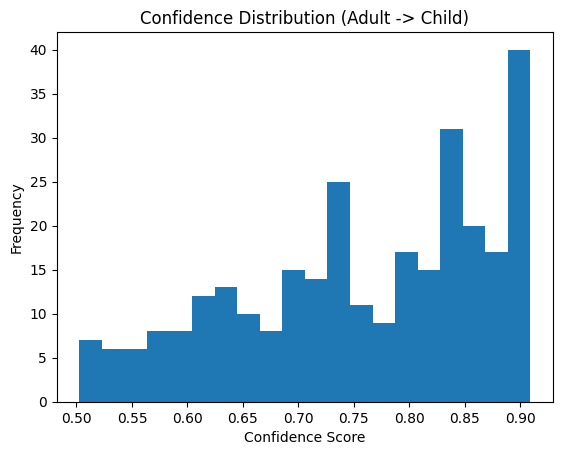


Ensemble AUROC (Child -> Adult, full): 0.7417064776288077
High-Confidence AUROC (Child -> Adult): 0.7871929026387625
High-Confidence %: 60.51136363636363
High-Confidence Sample Size: 426
Class Balance in High-Confidence Subset: [314 112]


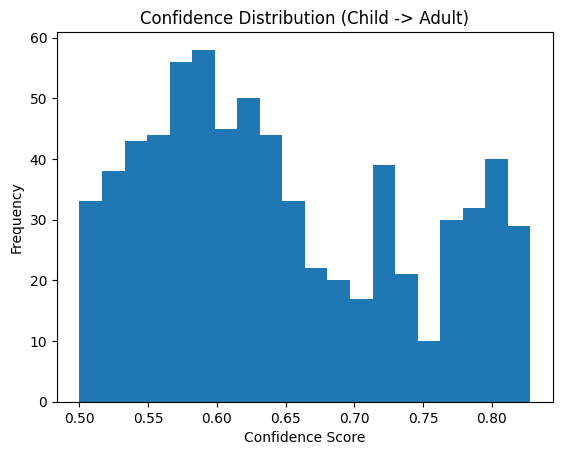

In [27]:

X_adult_proc = pd.read_csv('Adult_preprocessed_2aq.csv')
y_adult = pd.read_csv('Adult_labels_2aq.csv')
X_child_proc = pd.read_csv('Child_preprocessed_2aq.csv')
y_child = pd.read_csv('Child_labels_2aq.csv')

# Fix y
y_adult = y_adult.values.ravel()
y_child = y_child.values.ravel()

# Ensemble with balanced weights
models = {
    'Logistic Regression': LogisticRegression(random_state=42, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(random_state=42, class_weight='balanced'),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss', scale_pos_weight=len(y_adult)/(2*sum(y_adult)))
}
estimators = list(models.items())
ensemble = VotingClassifier(estimators, voting='soft')

# Train on Adult, test on Child
calibrated = CalibratedClassifierCV(ensemble, cv=5, method='sigmoid')  # Revert to sigmoid
calibrated.fit(X_adult_proc, y_adult)
probs = calibrated.predict_proba(X_child_proc)
confidences = np.max(probs, axis=1)
preds = calibrated.predict(X_child_proc)
high_conf_mask = confidences > 0.6  # Lower threshold
if high_conf_mask.sum() > 0:
    auroc_high = roc_auc_score(y_child[high_conf_mask], probs[high_conf_mask][:, 1])
else:
    auroc_high = np.nan
    print("Warning: No high-confidence predictions for Adult -> Child")

print("Ensemble AUROC (Adult -> Child, full):", roc_auc_score(y_child, probs[:, 1]))
print("High-Confidence AUROC (Adult -> Child):", auroc_high)
print("High-Confidence %:", high_conf_mask.mean() * 100)
print("High-Confidence Sample Size:", high_conf_mask.sum())
print("Class Balance in High-Confidence Subset:", np.bincount(y_child[high_conf_mask]))

# Plot
plt.hist(confidences, bins=20)
plt.title('Confidence Distribution (Adult -> Child)')
plt.xlabel('Confidence Score')
plt.ylabel('Frequency')
plt.savefig('confidence_adult_to_child.png')
plt.show()

# Train on Child, test on Adult
calibrated = CalibratedClassifierCV(VotingClassifier(estimators, voting='soft'), cv=5, method='sigmoid')
calibrated.fit(X_child_proc, y_child)
probs = calibrated.predict_proba(X_adult_proc)
confidences = np.max(probs, axis=1)
preds = calibrated.predict(X_adult_proc)
high_conf_mask = confidences > 0.6
if high_conf_mask.sum() > 0:
    auroc_high = roc_auc_score(y_adult[high_conf_mask], probs[high_conf_mask][:, 1])
else:
    auroc_high = np.nan
    print("Warning: No high-confidence predictions for Child -> Adult")

print("\nEnsemble AUROC (Child -> Adult, full):", roc_auc_score(y_adult, probs[:, 1]))
print("High-Confidence AUROC (Child -> Adult):", auroc_high)
print("High-Confidence %:", high_conf_mask.mean() * 100)
print("High-Confidence Sample Size:", high_conf_mask.sum())
print("Class Balance in High-Confidence Subset:", np.bincount(y_adult[high_conf_mask]))

# Plot
plt.hist(confidences, bins=20)
plt.title('Confidence Distribution (Child -> Adult)')
plt.xlabel('Confidence Score')
plt.ylabel('Frequency')
plt.savefig('confidence_child_to_adult.png')
plt.show()

Permutation Importance (Adult -> Child):
A1_Score: 0.1231
A2_Score: 0.0391
age: 0.0000
gender: 0.0097
ethnicity: 0.0202
jundice: 0.0000
austim: 0.0097
contry_of_res: 0.0000
relation: 0.0000


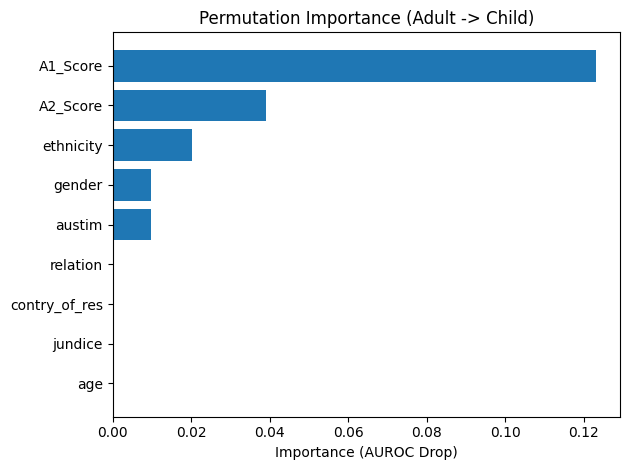


Permutation Importance (Child -> Adult):
A1_Score: 0.1268
A2_Score: 0.0459
age: 0.0082
gender: 0.0000
ethnicity: 0.0070
jundice: 0.0012
austim: 0.0000
contry_of_res: 0.0420
relation: 0.0007


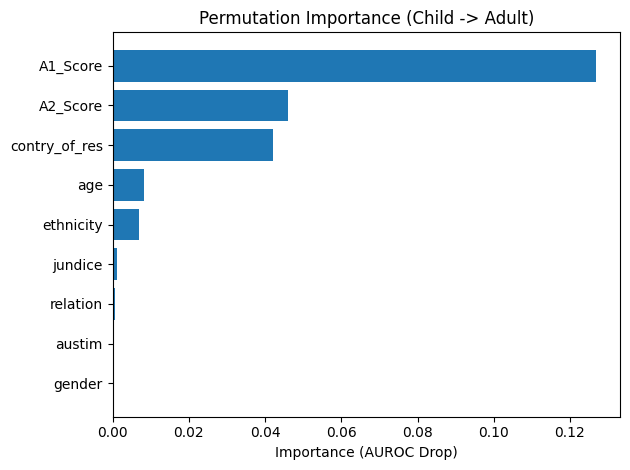

In [32]:
from sklearn.inspection import permutation_importance

# Load preprocessed CSVs
X_adult_proc = pd.read_csv('Adult_preprocessed_2aq.csv')
y_adult = pd.read_csv('Adult_labels_2aq.csv')
X_child_proc = pd.read_csv('Child_preprocessed_2aq.csv')
y_child = pd.read_csv('Child_labels_2aq.csv')

# Fix y
y_adult = y_adult.values.ravel()
y_child = y_child.values.ravel()

# Train Random Forest
model = RandomForestClassifier(random_state=42, class_weight='balanced')
model.fit(X_adult_proc, y_adult)

# Permutation importance (Adult -> Child)
perm_importance = permutation_importance(model, X_child_proc, y_child, n_repeats=10, random_state=42, scoring='roc_auc')
importances = np.clip(perm_importance.importances_mean, 0, None)  # Clip negative values to 0
print("Permutation Importance (Adult -> Child):")
for feature, importance in zip(X_child_proc.columns, importances):
    print(f"{feature}: {importance:.4f}")

# Plot
sorted_idx = importances.argsort()
plt.barh(X_child_proc.columns[sorted_idx], importances[sorted_idx])
plt.title('Permutation Importance (Adult -> Child)')
plt.xlabel('Importance (AUROC Drop)')
plt.tight_layout()
plt.savefig('perm_importance_adult_to_child.png')
plt.show()

# Train on Child, test on Adult
model.fit(X_child_proc, y_child)
perm_importance = permutation_importance(model, X_adult_proc, y_adult, n_repeats=10, random_state=42, scoring='roc_auc')
importances = np.clip(perm_importance.importances_mean, 0, None)  # Clip negative values to 0
print("\nPermutation Importance (Child -> Adult):")
for feature, importance in zip(X_adult_proc.columns, importances):
    print(f"{feature}: {importance:.4f}")

# Plot
sorted_idx = importances.argsort()
plt.barh(X_adult_proc.columns[sorted_idx], importances[sorted_idx])
plt.title('Permutation Importance (Child -> Adult)')
plt.xlabel('Importance (AUROC Drop)')
plt.tight_layout()
plt.savefig('perm_importance_child_to_adult.png')
plt.show()

In [33]:
# Load preprocessed CSVs
X_adult_proc = pd.read_csv('Adult_preprocessed_2aq.csv')
y_adult = pd.read_csv('Adult_labels_2aq.csv')
X_child_proc = pd.read_csv('Child_preprocessed_2aq.csv')
y_child = pd.read_csv('Child_labels_2aq.csv')

# Fix y
y_adult = y_adult.values.ravel()
y_child = y_child.values.ravel()

# Function to compute metrics by subgroup
def compute_subgroup_metrics(X, y, subgroup_col, subgroup_value, model, train_X, train_y):
    mask = X[subgroup_col] == subgroup_value
    if mask.sum() < 2:
        return np.nan, np.nan, np.nan
    model.fit(train_X, train_y)
    proba = model.predict_proba(X[mask])[:, 1]
    preds = model.predict(X[mask])
    return (roc_auc_score(y[mask], proba),
            recall_score(y[mask], preds, pos_label=1),
            recall_score(y[mask], preds, pos_label=0))

# Train Random Forest
model = RandomForestClassifier(random_state=42, class_weight='balanced')

# Gender fairness (assuming gender: 0=male, 1=female)
print("Gender Fairness (Adult -> Child):")
for gender in [0, 1]:
    auroc, sens, spec = compute_subgroup_metrics(X_child_proc, y_child, 'gender', gender, model, X_adult_proc, y_adult)
    print(f"Gender={gender}: AUROC={auroc:.3f}, Sensitivity={sens:.3f}, Specificity={spec:.3f}")

print("\nGender Fairness (Child -> Adult):")
for gender in [0, 1]:
    auroc, sens, spec = compute_subgroup_metrics(X_adult_proc, y_adult, 'gender', gender, model, X_child_proc, y_child)
    print(f"Gender={gender}: AUROC={auroc:.3f}, Sensitivity={sens:.3f}, Specificity={spec:.3f}")

Gender Fairness (Adult -> Child):
Gender=0: AUROC=0.701, Sensitivity=0.211, Specificity=0.913
Gender=1: AUROC=0.685, Sensitivity=0.078, Specificity=0.971

Gender Fairness (Child -> Adult):
Gender=0: AUROC=0.681, Sensitivity=0.612, Specificity=0.641
Gender=1: AUROC=0.796, Sensitivity=0.849, Specificity=0.662
